### IMDB Dataset [URL](http://ai.stanford.edu/~amaas/data/sentiment/) for Sentiment analysis for movies reviews 

### Word embedding projection [URL](http://projector.tensorflow.org/)

In [1]:
import tensorflow as tf
tf.enable_eager_execution()
import numpy as np

### Install the tenser flow dataset using below pip code
pip install -q tensorflow-datasets

### Import Imdb review dataset from tensorflow library

In [2]:
import tensorflow_datasets as tf_ds

In [3]:
imdb,info=tf_ds.load("imdb_reviews",with_info=True,as_supervised=True)

### Divide the dataset into training and testing set 25k on train and 25 k on test

In [4]:
data_train,data_test=imdb['train'],imdb['test']

In [5]:
x_train=[] # Sentance of review of training data (data_train)
y_train=[] # label of review of training data (data_train)
x_test=[] # Sentance of review of testing data (data_test)
y_test=[] # label of review of testing data (data_test)

### Run the for loop and append each sentance and lables in array

In [6]:
for x,y in data_train:
    x_train.append(str(x.numpy()))
    y_train.append(str(y.numpy()))

In [7]:
for x,y in data_test:
    x_test.append(str(x.numpy()))
    y_test.append(str(y.numpy()))

### Converting all the labels(y_train,y_test) into numpy array

In [8]:
y_train_final=np.array(y_train)
y_test_final=np.array(y_test)

In [9]:
y_train_final.dtype

dtype('<U1')

In [10]:
y_train_final=y_train_final.astype('int32') 
y_test_final=y_test_final.astype('int32')

### Declearing the important variable for word imbedding 

In [11]:
vocab_size=10000
embed_dim=16
max_len=120
trunc_type='post'
oov_tok="<OOV>"
num_epochs = 10

### Tokenize the sentance into word  and Pad the data to form the same length of sequience of data

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [13]:
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
#fit_on_texts will take the data and encode it
tokenizer.fit_on_texts(x_train)
#it will provide the word index property in dectionary form
word_index=tokenizer.word_index

In [14]:
x_train_sequences=tokenizer.texts_to_sequences(x_train)
x_train_padded=pad_sequences(x_train_sequences,maxlen=max_len,truncating=trunc_type)

In [15]:
#fit_on_texts will take the data and encode it
tokenizer.fit_on_texts(x_test)
#it will provide the word index property in dectionary form
word_index=tokenizer.word_index

In [16]:
x_test_sequences=tokenizer.texts_to_sequences(x_test)
x_test_padded=pad_sequences(x_test_sequences,maxlen=max_len)

### Building a keras model

In [17]:
model=tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embed_dim,input_length=max_len),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(12,activation="tanh"),
    tf.keras.layers.Dense(8,activation="tanh"),
    tf.keras.layers.Dense(6,activation="tanh"),
    tf.keras.layers.Dense(1,activation="sigmoid")    
])

### How can we use the vector

In [18]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.001)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 12)                23052     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 183,217
Trainable params: 183,217
Non-trainable params: 0
__________________________________________________

In [27]:
earlyStopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.01) 

modelCheckpoint = ModelCheckpoint('word_embedding.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [28]:
history=model.fit(x_train_padded, y_train_final,batch_size = 32,callbacks=[earlyStopping,modelCheckpoint], epochs=num_epochs, validation_data=(x_test_padded, y_test_final))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
24864/25000 [============================>.] - ETA: 0s - loss: 0.3270 - acc: 0.8788
Epoch 00001: val_acc improved from -inf to 0.61232, saving model to word_embedding.hdf5
25000/25000 [==============================] - 5s 200us/sample - loss: 0.3271 - acc: 0.8788 - val_loss: 0.7007 - val_acc: 0.6123
Epoch 2/10
24864/25000 [============================>.] - ETA: 0s - loss: 0.3161 - acc: 0.8817
Epoch 00002: val_acc did not improve from 0.61232
25000/25000 [==============================] - 4s 172us/sample - loss: 0.3159 - acc: 0.8819 - val_loss: 0.7101 - val_acc: 0.6098
Epoch 3/10
24736/25000 [============================>.] - ETA: 0s - loss: 0.3059 - acc: 0.8864
Epoch 00003: val_acc did not improve from 0.61232
25000/25000 [==============================] - 4s 172us/sample - loss: 0.3062 - acc: 0.8863 - val_loss: 0.7175 - val_acc: 0.6087
Epoch 4/10
24800/25000 [============================>.] - ETA: 0s - loss: 0.2977 - acc: 0.

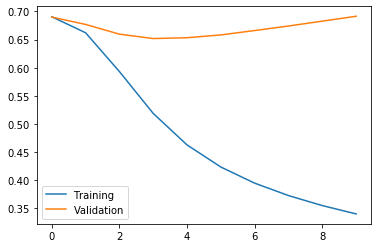

In [21]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='Training') 
pyplot.plot(history.history['val_loss'], label='Validation') 
pyplot.legend()
pyplot.show()

### from the above grapg we can clearly say our model is overfitted so we need to improve the model

In [22]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [23]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(x_train_padded[1]))
print(x_train[1])

b 'll into i was so horror loves and <OOV> very i almost it this for was the channel of seen <OOV> cinderella movie were i disappointment many it since i was in underused adult at a <OOV> perhaps so i kind not sure some mess it would have on were now however i other say that it let an 80 on were and most of my full it know rings them pieces at interesting stupid we me funny fact and <OOV> fact to noel and brings our comedy carradine i was extremely accomplish of some the settle mister ben herd timothy had to blew very not psychology the total of the 14 i part want to versions the for
b"Perhaps because I was so young, innocent and BRAINWASHED when I saw it, this movie was the cause of many sleepless nights for me. I haven't seen it since I was in seventh grade at a Presbyterian school, so I am not sure what effect it would have on me now. However, I will say that it left an impression on me... and most of my friends. It did serve its purpose, at least until we were old enough and knowle

### here we are just revesing the order of word and number (word:number to number:word)

In [24]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [26]:
sentence = "I think this is good."
sequence = tokenizer.texts_to_sequences(sentence)
print(sequence)

[[11], [], [775], [2132], [11], [2841], [1925], [], [775], [2132], [11], [574], [], [11], [574], [], [1260], [939], [939], [922], []]
